<a href="https://colab.research.google.com/github/gracchen/bionics-lab-hand-plots/blob/main/plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Method
Below is the code to smooth (remove jumps), normalize (start at 0 degrees and use same y-range for sets of x,y,z plots), and plot all of the csv files for the first four hand tests. All the plots can be found in this google drive directory in the plots folder, either raw or normalized, sorted by test.

In [1]:
from google.colab import drive
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt

drive.mount('/content/drive', force_remount=True)

folder = '/content/drive/My Drive/Bionics Lab Research/Hand Sensors_Data Processing/'
data_path = folder + 'HandSensorData_05312024/Grace/'

Mounted at /content/drive


## Helper Functions to smooth and plot:

# Four-way Dist Plots

In [ ]:
# smoothen and plot:

def smooth_data(MotionData, col_name):
    """
    Takes the file dataframe and desired column to smooth (i.e. thumb01x)
    iterates through each element of the column (angle data) and smooths any
    jumps in the data with a constant being the difference between before and
    after the jump. Comment out the second last line to disable normalizing.
    """
    data = MotionData[col_name].copy()  # Create a copy of the column data
    i = 1
    while i < len(data):
      if abs(data[i-1] - data[i]) > 10:  # Jump detected
        constant = data[i-1] - data[i]
        data[i:] += constant
      i += 1
    MotionData[col_name] = data  # Update the column in the original DataFrame

def smooth_file(file_name, cols = None):
    """
    repeats smoothening for all desired columns (3 axes of 2 measured fingers)
    """
    print(f"reading {data_path+file_name}")
    MotionData = pd.read_csv(data_path+file_name)
    if cols is None:
      for finger in ['Thumb', 'Index']:
        for axis in ['x', 'y', 'z']:
          smooth_data(MotionData, finger+'01'+axis)
    else:
      for col in cols:
          smooth_data(MotionData, col)
    return MotionData

testnames = ["MassFlexion", "MassExtension", "HookGrasp", "ThumbAdduction",  "PencilGrasp", "CylinderGrasp", "SphericalGrasp"]
def graph_file(file_name, test_name, hand, save_path = None, cols=None, color='blue', plot_ratios=False):
    """
    generates smoothened plots of x,y,z for one csv file given path, test name,
    hand (left or right). If save_path defined, will save the plot as image in
    plots folder, otherwise will display it.
    """
    test_index = testnames.index(test_name)
    df = smooth_file(file_name, cols)  # Smooth the data first

    dfs = []

    if cols is None: cols = ['Index', 'Thumb']
    for finger, color in zip(['Index', 'Thumb'],['blue', 'orange']):
      fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(40, 10)) # increased height
      # get min and max across all important columns in this file:
      max_range = max(
          max(df[finger + '01x'].tolist()) - min(df[finger + '01x'].tolist()),
          max(df[finger + '01y'].tolist())  - min(df[finger + '01y'].tolist()),
          max(df[finger + '01z'].tolist())  - min(df[finger + '01z'].tolist())
      )

      # avoid scrolling if displaying one plot:
      from IPython.display import Javascript
      display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

      # generate the 3 plots as one image, aligned via x-axis (time)
      for axis,plt_id in zip(['x','y','z'], [ax1,ax2,ax3]):
        plt_id.plot(df['Timestamp'], df[finger + '01'+axis], label = finger + '1' + axis, color=color)
        plt_id.legend();
        plt_id.set(xlabel ='time', ylabel = 'degrees')
        plt_id.set_title(test_name + ' ' + hand + ' Hand ' + axis + '-axis')
        plt_id.set_ylim(min(df[finger+'01'+axis].tolist()), min(df[finger+'01'+axis].tolist())+max_range)

      # generate normalized 4th combination plot
      for axis,color in zip(['x','y','z'], ['red', 'green', 'blue']):
        df[finger + '01'+axis] -= df[finger + '01'+axis][0]
        ax4.plot(df['Timestamp'], df[finger + '01'+axis], label = finger + '1' + axis, color=color)
      ax4.legend();
      ax4.set(xlabel ='time', ylabel = 'degrees')
      ax4.set_title(test_name + ' ' + hand + ' Hand ' + axis + '-axis')

      # show or save the image:
      if save_path is not None:
        file_prefix = os.path.splitext(file_name)[0] + "-" + finger  # Get the filename without extension
        os.makedirs(save_path, exist_ok=True)
        save_file_path = os.path.join(save_path, f"{test_index}{file_prefix}.png")
        print(f"saving to {save_file_path}")
        plt_id.figure.savefig(save_file_path, transparent=False)
        plt.close()  # to avoid showing a bajillion plots
      else:
        plt.show()

      dfs.append(df)

    if plot_ratios:
      df = compute_ratio(df, 'Hand_pos_', 'ThumbCMC', 'ThumbMCP', 'Thumb_Hand_dist_ratio')
      smooth_data(df, 'Thumb_Hand_dist_ratio')
      df = compute_ratio(df, 'Hand_pos_', 'IndexMCP', 'IndexPIP', 'Index_Hand_dist_ratio')
      smooth_data(df, 'Index_Hand_dist_ratio')
      df = compute_ratio(df, 'ThumbMCP', 'IndexMCP', 'IndexPIP', 'Index_Thumb_dist_ratio')
      smooth_data(df, 'Index_Thumb_dist_ratio')

      fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5)) # increased height
      # get min and max across all important columns in this file:
      max_range = max(
          max(df['Thumb_Hand_dist_ratio'].tolist()) - min(df['Thumb_Hand_dist_ratio'].tolist()),
          max(df['Index_Hand_dist_ratio'].tolist())  - min(df['Index_Hand_dist_ratio'].tolist()),
          max(df['Index_Thumb_dist_ratio'].tolist())  - min(df['Index_Thumb_dist_ratio'].tolist())
      )

      # avoid scrolling if displaying one plot:
      from IPython.display import Javascript
      display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

      # generate the 3 plots as one image, aligned via ratios
      for ratio,plt_id,label in zip(['Thumb_Hand_dist_ratio','Index_Hand_dist_ratio','Index_Thumb_dist_ratio'], [ax1,ax2,ax3], \
       ['dist(Hand, ThumbMCP) ÷ dist(Hand, ThumbCMC)', 'dist(Hand, IndexPIP) ÷ dist(Hand, IndexMCP)', 'dist(ThumbMCP, IndexPIP) ÷ dist(ThumbMCP, IndexMCP)']):
        plt_id.plot(df['Timestamp'], df[ratio], label = ratio, color=color)
        plt_id.legend();
        plt_id.set(xlabel ='time', ylabel = label)
        plt_id.set_title(test_name + ' ' + hand + ' Hand ' + ratio)
        plt_id.set_ylim(min(df[ratio].tolist()), min(df[ratio].tolist())+max_range)

      # generate normalized 4th combination plot
      for ratio,color in zip(['Thumb_Hand_dist_ratio','Index_Hand_dist_ratio','Index_Thumb_dist_ratio'], ['red', 'green', 'blue']):
        df[ratio] -= df[ratio][0]
        ax4.plot(df['Timestamp'], df[ratio], label = "all distance ratios", color=color)
      ax4.legend();
      ax4.set(xlabel ='time', ylabel = 'ratios')
      ax4.set_title(test_name + ' ' + hand + ' Hand ' + ratio)

      # show or save the image:
      if save_path is not None:
        file_prefix = os.path.splitext(file_name)[0] + "-ratios"  # Get the filename without extension
        os.makedirs(save_path, exist_ok=True)
        save_file_path = os.path.join(save_path, f"{test_index}{file_prefix}.png")
        print(f"saving to {save_file_path}")
        plt_id.figure.savefig(save_file_path, transparent=False)
        plt.close()  # to avoid showing a bajillion plots
      else:
        plt.show()

      dfs.append(df)

    return dfs

In [ ]:
# general func to compute dist(base, joint2) / dist(base, joint1)
def compute_ratio(file, base, joint1, joint2, output):
  if isinstance(file, str):
    df = pd.read_csv(folder+file)
  else: df = file
  shape = df['Handx'].shape
  for joint in [base, joint1, joint2]:
    for axis in ['x', 'y', 'z']:
      smooth_data(df, joint+axis)

  base_dfs = [df[base+'x'],df[base+'y'],df[base+'z']]
  joint1_dfs = [df[joint1+'x'],df[joint1+'y'],df[joint1+'z']]
  joint2_dfs = [df[joint2+'x'],df[joint2+'y'],df[joint2+'z']]

  dist1 = np.sqrt((joint1_dfs[0] - base_dfs[0])**2 + (joint1_dfs[1] - base_dfs[1])**2 + (joint1_dfs[2] - base_dfs[2])**2)
  dist2 = np.sqrt((joint2_dfs[0] - base_dfs[0])**2 + (joint2_dfs[1] - base_dfs[1])**2 + (joint2_dfs[2] - base_dfs[2])**2)

  df[output] = np.where(dist1 != 0, dist2 / dist1, 0)
  return df

In [ ]:
# grab all the csvs and divide into filenames[test#][right/left] dictionary
folder = '/content/drive/My Drive/Bionics Lab Research/'
data_path = folder + 'FMA_HANDSENSOR_DATA/ID02_PKN8M6L_EB242406061802/'
#data_path = folder + 'HandSensorData_05242024/'

import os
file_list = os.listdir(data_path)

filenames = {}
testnames = ["MassFlexion", "MassExtension", "HookGrasp", "ThumbAdduction",  "PencilGrasp", "CylinderGrasp", "SphericalGrasp"]
for testname, testno in zip(testnames, range(0,len(testnames))):
    filenames[testno] = {'right': [filename for filename in file_list if testname in filename and 'Right' in filename],
                        'left': [filename for filename in file_list if testname in filename and 'Left' in filename]}

filenames

{0: {'right': ['RightHand_06_18_2024_11_21_58_1MassFlexion.csv',
   'RightHand_06_18_2024_11_21_40_1MassFlexion.csv'],
  'left': ['LeftHand_06_18_2024_11_31_56_1MassFlexion.csv',
   'LeftHand_06_18_2024_11_32_02_1MassFlexion.csv']},
 1: {'right': ['RightHand_06_18_2024_11_22_30_2MassExtension.csv',
   'RightHand_06_18_2024_11_22_38_2MassExtension.csv'],
  'left': ['LeftHand_06_18_2024_11_32_16_2MassExtension.csv',
   'LeftHand_06_18_2024_11_32_23_2MassExtension.csv']},
 2: {'right': ['RightHand_06_18_2024_11_24_02_3HookGrasp.csv',
   'RightHand_06_18_2024_11_23_01_3HookGrasp.csv',
   'RightHand_06_18_2024_11_24_58_3HookGrasp_withHand.csv'],
  'left': ['LeftHand_06_18_2024_11_33_58_3HookGrasp_withHand.csv',
   'LeftHand_06_18_2024_11_33_05_3HookGrasp.csv',
   'LeftHand_06_18_2024_11_33_35_3HookGrasp.csv']},
 3: {'right': ['RightHand_06_18_2024_11_26_56_4ThumbAdduction.csv',
   'RightHand_06_18_2024_11_26_31_4ThumbAdduction.csv'],
  'left': ['LeftHand_06_18_2024_11_34_56_4ThumbAdduction.

reading /content/drive/My Drive/Bionics Lab Research/HandSensorData_05242024/RightHand_05_24_2024_18_19_53_6CylinderGrasp.csv


<IPython.core.display.Javascript object>

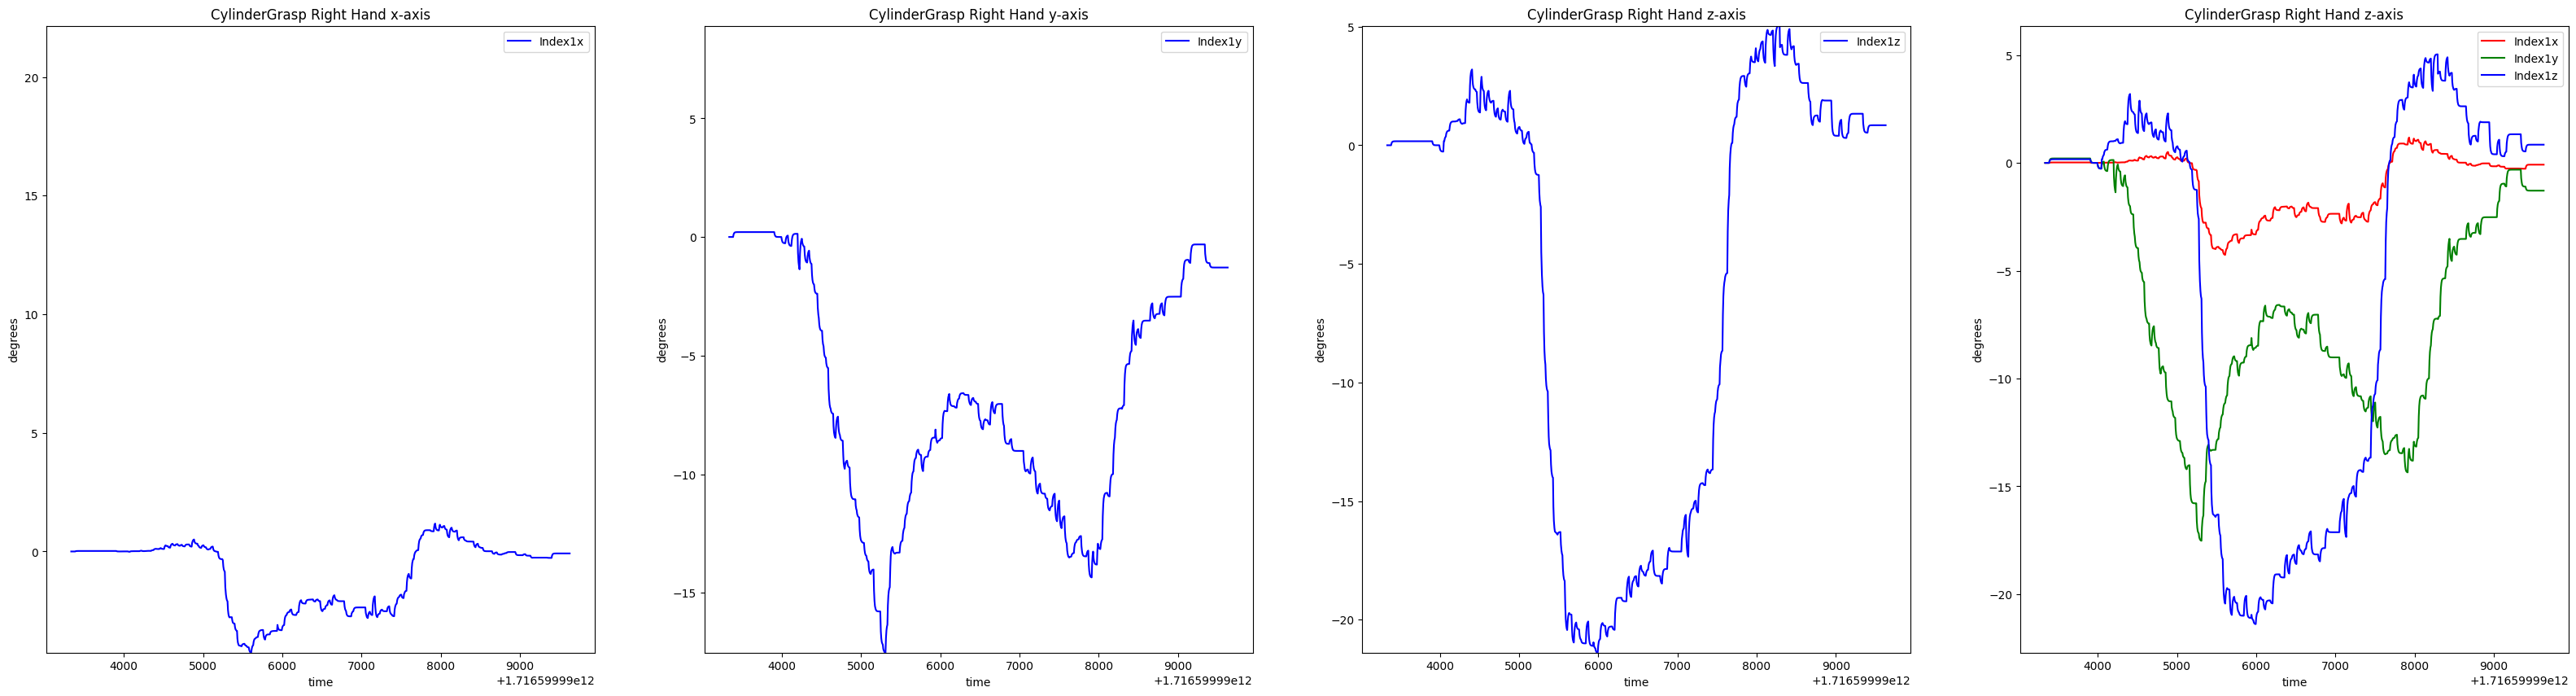

<IPython.core.display.Javascript object>

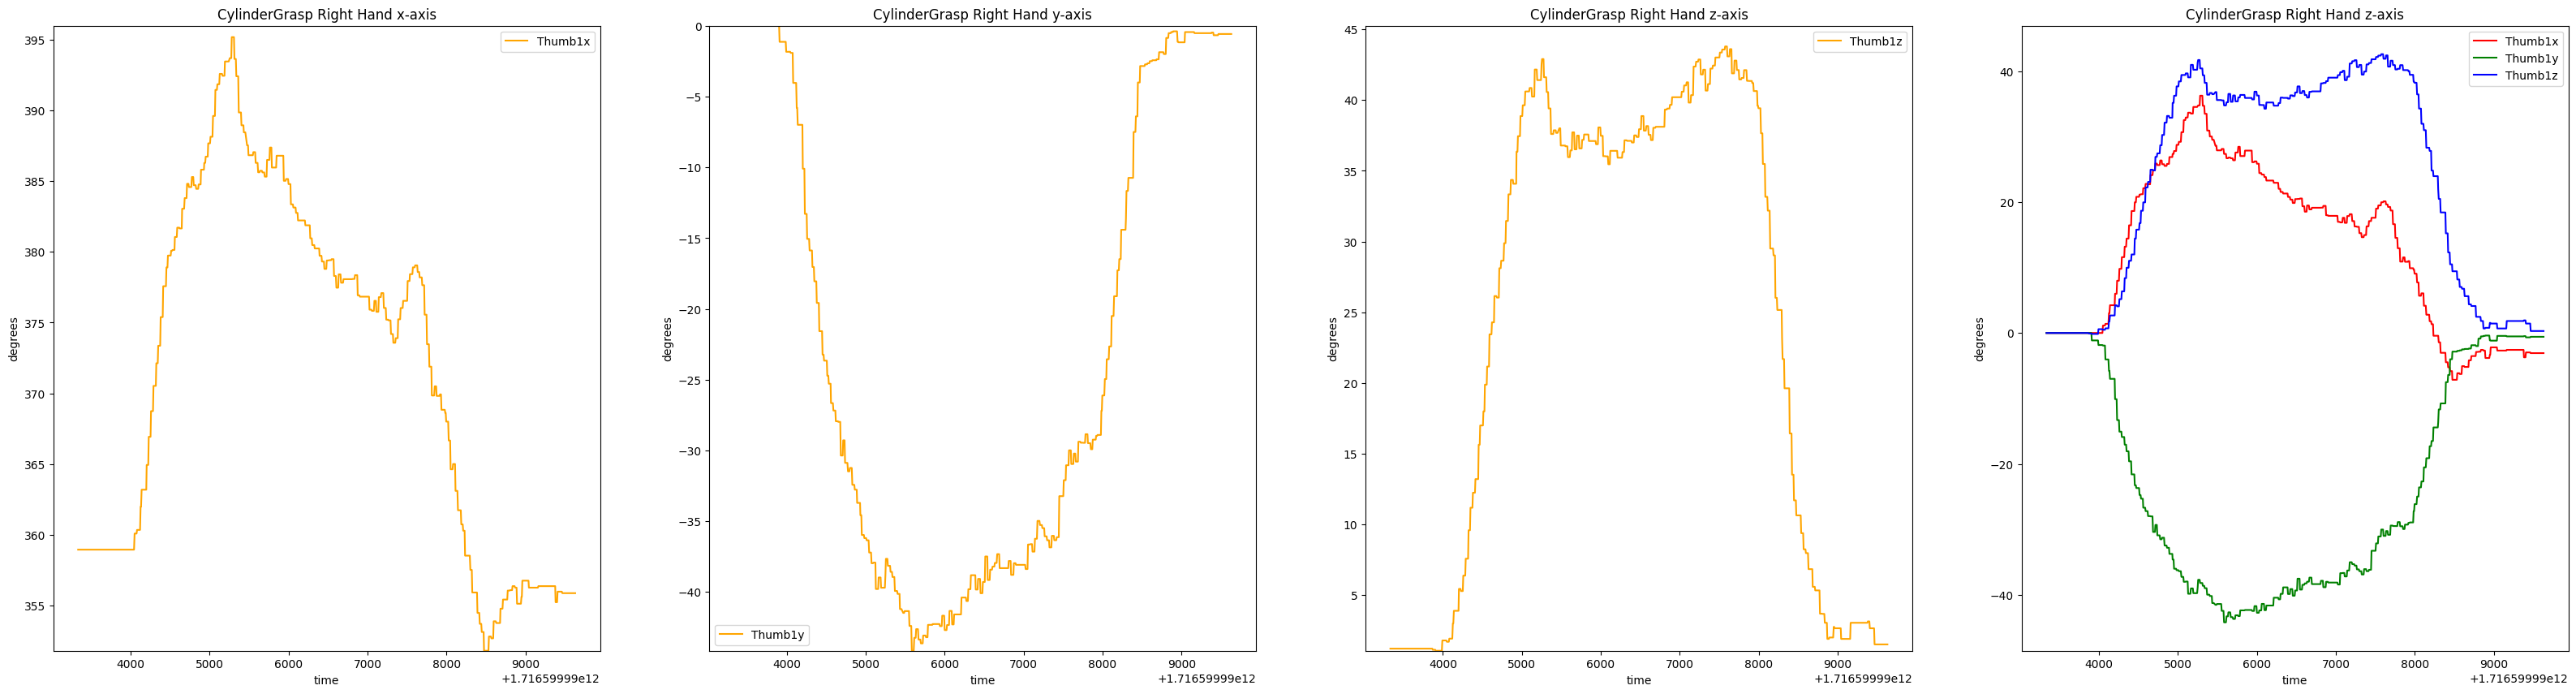

<IPython.core.display.Javascript object>

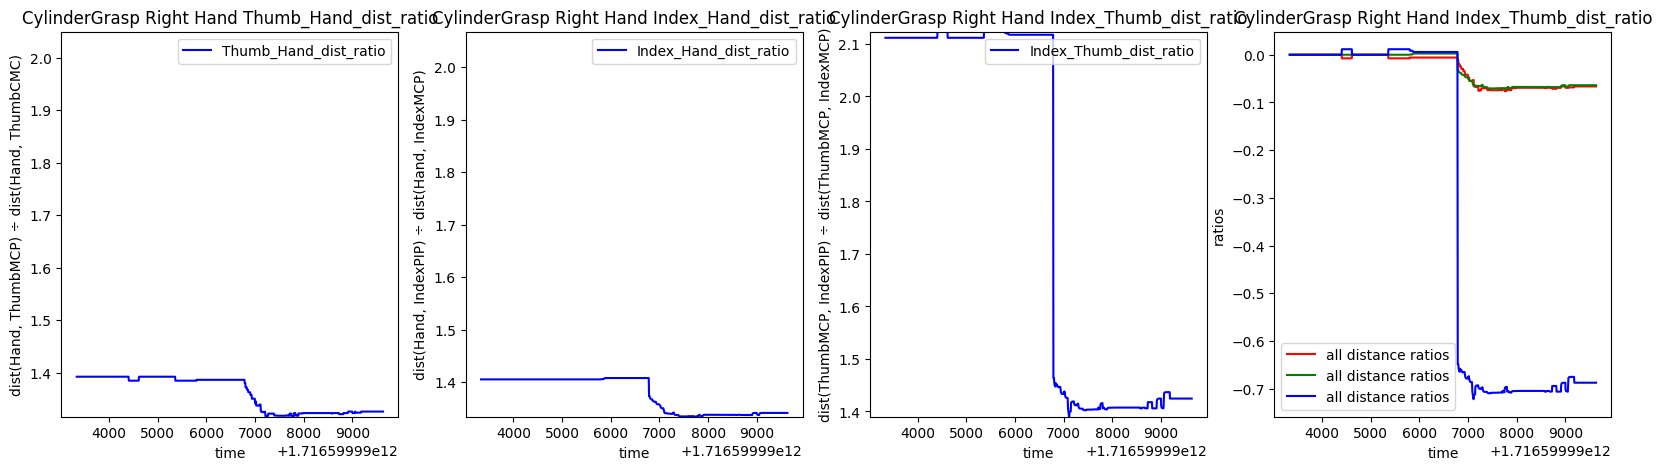

In [ ]:
df = graph_file('RightHand_05_24_2024_18_19_53_6CylinderGrasp.csv', 'CylinderGrasp', "Right", plot_ratios=True)

In [ ]:
# generate and save batch of all plots:
for testno in range(len(testnames)):
    for hand in ['right', 'left']:
        for file_name in filenames[testno][hand]:
            save_folder = os.path.join(folder, f"Grace/plots-6-28/")
            os.makedirs(save_folder, exist_ok=True)
            graph_file(file_name, testnames[testno], hand.capitalize(), save_path=save_folder, name="", plot_ratios=True)
            #print(f"graph_file({file_name}, {testnames[testno]}, {hand.capitalize()}, {save_folder})")

reading /content/drive/My Drive/Bionics Lab Research/FMA_HANDSENSOR_DATA/ID02_PKN8M6L_EB242406061802/RightHand_06_18_2024_11_21_58_1MassFlexion.csv


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/0RightHand_06_18_2024_11_21_58_1MassFlexion-Index.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/0RightHand_06_18_2024_11_21_58_1MassFlexion-Thumb.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/0RightHand_06_18_2024_11_21_58_1MassFlexion-ratios.png
reading /content/drive/My Drive/Bionics Lab Research/FMA_HANDSENSOR_DATA/ID02_PKN8M6L_EB242406061802/RightHand_06_18_2024_11_21_40_1MassFlexion.csv


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/0RightHand_06_18_2024_11_21_40_1MassFlexion-Index.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/0RightHand_06_18_2024_11_21_40_1MassFlexion-Thumb.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/0RightHand_06_18_2024_11_21_40_1MassFlexion-ratios.png
reading /content/drive/My Drive/Bionics Lab Research/FMA_HANDSENSOR_DATA/ID02_PKN8M6L_EB242406061802/LeftHand_06_18_2024_11_31_56_1MassFlexion.csv


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/0LeftHand_06_18_2024_11_31_56_1MassFlexion-Index.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/0LeftHand_06_18_2024_11_31_56_1MassFlexion-Thumb.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/0LeftHand_06_18_2024_11_31_56_1MassFlexion-ratios.png
reading /content/drive/My Drive/Bionics Lab Research/FMA_HANDSENSOR_DATA/ID02_PKN8M6L_EB242406061802/LeftHand_06_18_2024_11_32_02_1MassFlexion.csv


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/0LeftHand_06_18_2024_11_32_02_1MassFlexion-Index.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/0LeftHand_06_18_2024_11_32_02_1MassFlexion-Thumb.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/0LeftHand_06_18_2024_11_32_02_1MassFlexion-ratios.png
reading /content/drive/My Drive/Bionics Lab Research/FMA_HANDSENSOR_DATA/ID02_PKN8M6L_EB242406061802/RightHand_06_18_2024_11_22_30_2MassExtension.csv


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/1RightHand_06_18_2024_11_22_30_2MassExtension-Index.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/1RightHand_06_18_2024_11_22_30_2MassExtension-Thumb.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/1RightHand_06_18_2024_11_22_30_2MassExtension-ratios.png
reading /content/drive/My Drive/Bionics Lab Research/FMA_HANDSENSOR_DATA/ID02_PKN8M6L_EB242406061802/RightHand_06_18_2024_11_22_38_2MassExtension.csv


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/1RightHand_06_18_2024_11_22_38_2MassExtension-Index.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/1RightHand_06_18_2024_11_22_38_2MassExtension-Thumb.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/1RightHand_06_18_2024_11_22_38_2MassExtension-ratios.png
reading /content/drive/My Drive/Bionics Lab Research/FMA_HANDSENSOR_DATA/ID02_PKN8M6L_EB242406061802/LeftHand_06_18_2024_11_32_16_2MassExtension.csv


<IPython.core.display.Javascript object>

<ipython-input-3-20471f27d0d0>:66: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt_id.set_ylim(min(df[finger+'01'+axis].tolist()), min(df[finger+'01'+axis].tolist())+max_range)


saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/1LeftHand_06_18_2024_11_32_16_2MassExtension-Index.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/1LeftHand_06_18_2024_11_32_16_2MassExtension-Thumb.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/1LeftHand_06_18_2024_11_32_16_2MassExtension-ratios.png
reading /content/drive/My Drive/Bionics Lab Research/FMA_HANDSENSOR_DATA/ID02_PKN8M6L_EB242406061802/LeftHand_06_18_2024_11_32_23_2MassExtension.csv


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/1LeftHand_06_18_2024_11_32_23_2MassExtension-Index.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/1LeftHand_06_18_2024_11_32_23_2MassExtension-Thumb.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/1LeftHand_06_18_2024_11_32_23_2MassExtension-ratios.png
reading /content/drive/My Drive/Bionics Lab Research/FMA_HANDSENSOR_DATA/ID02_PKN8M6L_EB242406061802/RightHand_06_18_2024_11_24_02_3HookGrasp.csv


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/2RightHand_06_18_2024_11_24_02_3HookGrasp-Index.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/2RightHand_06_18_2024_11_24_02_3HookGrasp-Thumb.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/2RightHand_06_18_2024_11_24_02_3HookGrasp-ratios.png
reading /content/drive/My Drive/Bionics Lab Research/FMA_HANDSENSOR_DATA/ID02_PKN8M6L_EB242406061802/RightHand_06_18_2024_11_23_01_3HookGrasp.csv


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/2RightHand_06_18_2024_11_23_01_3HookGrasp-Index.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/2RightHand_06_18_2024_11_23_01_3HookGrasp-Thumb.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/2RightHand_06_18_2024_11_23_01_3HookGrasp-ratios.png
reading /content/drive/My Drive/Bionics Lab Research/FMA_HANDSENSOR_DATA/ID02_PKN8M6L_EB242406061802/RightHand_06_18_2024_11_24_58_3HookGrasp_withHand.csv


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/2RightHand_06_18_2024_11_24_58_3HookGrasp_withHand-Index.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/2RightHand_06_18_2024_11_24_58_3HookGrasp_withHand-Thumb.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/2RightHand_06_18_2024_11_24_58_3HookGrasp_withHand-ratios.png
reading /content/drive/My Drive/Bionics Lab Research/FMA_HANDSENSOR_DATA/ID02_PKN8M6L_EB242406061802/LeftHand_06_18_2024_11_33_58_3HookGrasp_withHand.csv


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/2LeftHand_06_18_2024_11_33_58_3HookGrasp_withHand-Index.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/2LeftHand_06_18_2024_11_33_58_3HookGrasp_withHand-Thumb.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/2LeftHand_06_18_2024_11_33_58_3HookGrasp_withHand-ratios.png
reading /content/drive/My Drive/Bionics Lab Research/FMA_HANDSENSOR_DATA/ID02_PKN8M6L_EB242406061802/LeftHand_06_18_2024_11_33_05_3HookGrasp.csv


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/2LeftHand_06_18_2024_11_33_05_3HookGrasp-Index.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/2LeftHand_06_18_2024_11_33_05_3HookGrasp-Thumb.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/2LeftHand_06_18_2024_11_33_05_3HookGrasp-ratios.png
reading /content/drive/My Drive/Bionics Lab Research/FMA_HANDSENSOR_DATA/ID02_PKN8M6L_EB242406061802/LeftHand_06_18_2024_11_33_35_3HookGrasp.csv


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/2LeftHand_06_18_2024_11_33_35_3HookGrasp-Index.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/2LeftHand_06_18_2024_11_33_35_3HookGrasp-Thumb.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/2LeftHand_06_18_2024_11_33_35_3HookGrasp-ratios.png
reading /content/drive/My Drive/Bionics Lab Research/FMA_HANDSENSOR_DATA/ID02_PKN8M6L_EB242406061802/RightHand_06_18_2024_11_26_56_4ThumbAdduction.csv


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/3RightHand_06_18_2024_11_26_56_4ThumbAdduction-Index.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/3RightHand_06_18_2024_11_26_56_4ThumbAdduction-Thumb.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/3RightHand_06_18_2024_11_26_56_4ThumbAdduction-ratios.png
reading /content/drive/My Drive/Bionics Lab Research/FMA_HANDSENSOR_DATA/ID02_PKN8M6L_EB242406061802/RightHand_06_18_2024_11_26_31_4ThumbAdduction.csv


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/3RightHand_06_18_2024_11_26_31_4ThumbAdduction-Index.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/3RightHand_06_18_2024_11_26_31_4ThumbAdduction-Thumb.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/3RightHand_06_18_2024_11_26_31_4ThumbAdduction-ratios.png
reading /content/drive/My Drive/Bionics Lab Research/FMA_HANDSENSOR_DATA/ID02_PKN8M6L_EB242406061802/LeftHand_06_18_2024_11_34_56_4ThumbAdduction.csv


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/3LeftHand_06_18_2024_11_34_56_4ThumbAdduction-Index.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/3LeftHand_06_18_2024_11_34_56_4ThumbAdduction-Thumb.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/3LeftHand_06_18_2024_11_34_56_4ThumbAdduction-ratios.png
reading /content/drive/My Drive/Bionics Lab Research/FMA_HANDSENSOR_DATA/ID02_PKN8M6L_EB242406061802/LeftHand_06_18_2024_11_34_29_4ThumbAdduction.csv


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/3LeftHand_06_18_2024_11_34_29_4ThumbAdduction-Index.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/3LeftHand_06_18_2024_11_34_29_4ThumbAdduction-Thumb.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/3LeftHand_06_18_2024_11_34_29_4ThumbAdduction-ratios.png
reading /content/drive/My Drive/Bionics Lab Research/FMA_HANDSENSOR_DATA/ID02_PKN8M6L_EB242406061802/RightHand_06_18_2024_11_27_57_5PencilGrasp.csv


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/4RightHand_06_18_2024_11_27_57_5PencilGrasp-Index.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/4RightHand_06_18_2024_11_27_57_5PencilGrasp-Thumb.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/4RightHand_06_18_2024_11_27_57_5PencilGrasp-ratios.png
reading /content/drive/My Drive/Bionics Lab Research/FMA_HANDSENSOR_DATA/ID02_PKN8M6L_EB242406061802/RightHand_06_18_2024_11_28_13_5PencilGrasp.csv


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/4RightHand_06_18_2024_11_28_13_5PencilGrasp-Index.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/4RightHand_06_18_2024_11_28_13_5PencilGrasp-Thumb.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/4RightHand_06_18_2024_11_28_13_5PencilGrasp-ratios.png
reading /content/drive/My Drive/Bionics Lab Research/FMA_HANDSENSOR_DATA/ID02_PKN8M6L_EB242406061802/RightHand_06_18_2024_11_28_31_5PencilGrasp_withRealPencil.csv


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/4RightHand_06_18_2024_11_28_31_5PencilGrasp_withRealPencil-Index.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/4RightHand_06_18_2024_11_28_31_5PencilGrasp_withRealPencil-Thumb.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/4RightHand_06_18_2024_11_28_31_5PencilGrasp_withRealPencil-ratios.png
reading /content/drive/My Drive/Bionics Lab Research/FMA_HANDSENSOR_DATA/ID02_PKN8M6L_EB242406061802/LeftHand_06_18_2024_11_39_01_5PencilGrasp.csv


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/4LeftHand_06_18_2024_11_39_01_5PencilGrasp-Index.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/4LeftHand_06_18_2024_11_39_01_5PencilGrasp-Thumb.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/4LeftHand_06_18_2024_11_39_01_5PencilGrasp-ratios.png
reading /content/drive/My Drive/Bionics Lab Research/FMA_HANDSENSOR_DATA/ID02_PKN8M6L_EB242406061802/LeftHand_06_18_2024_11_35_41_5PencilGrasp.csv


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/4LeftHand_06_18_2024_11_35_41_5PencilGrasp-Index.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/4LeftHand_06_18_2024_11_35_41_5PencilGrasp-Thumb.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/4LeftHand_06_18_2024_11_35_41_5PencilGrasp-ratios.png
reading /content/drive/My Drive/Bionics Lab Research/FMA_HANDSENSOR_DATA/ID02_PKN8M6L_EB242406061802/LeftHand_06_18_2024_11_41_09_5PencilGrasp_withRealPencil.csv


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/4LeftHand_06_18_2024_11_41_09_5PencilGrasp_withRealPencil-Index.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/4LeftHand_06_18_2024_11_41_09_5PencilGrasp_withRealPencil-Thumb.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/4LeftHand_06_18_2024_11_41_09_5PencilGrasp_withRealPencil-ratios.png
reading /content/drive/My Drive/Bionics Lab Research/FMA_HANDSENSOR_DATA/ID02_PKN8M6L_EB242406061802/RightHand_06_18_2024_11_28_57_6CylinderGrasp.csv


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/5RightHand_06_18_2024_11_28_57_6CylinderGrasp-Index.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/5RightHand_06_18_2024_11_28_57_6CylinderGrasp-Thumb.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/5RightHand_06_18_2024_11_28_57_6CylinderGrasp-ratios.png
reading /content/drive/My Drive/Bionics Lab Research/FMA_HANDSENSOR_DATA/ID02_PKN8M6L_EB242406061802/RightHand_06_18_2024_11_29_17_6CylinderGrasp.csv


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/5RightHand_06_18_2024_11_29_17_6CylinderGrasp-Index.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/5RightHand_06_18_2024_11_29_17_6CylinderGrasp-Thumb.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/5RightHand_06_18_2024_11_29_17_6CylinderGrasp-ratios.png
reading /content/drive/My Drive/Bionics Lab Research/FMA_HANDSENSOR_DATA/ID02_PKN8M6L_EB242406061802/LeftHand_06_18_2024_11_39_57_6CylinderGrasp.csv


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/5LeftHand_06_18_2024_11_39_57_6CylinderGrasp-Index.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/5LeftHand_06_18_2024_11_39_57_6CylinderGrasp-Thumb.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/5LeftHand_06_18_2024_11_39_57_6CylinderGrasp-ratios.png
reading /content/drive/My Drive/Bionics Lab Research/FMA_HANDSENSOR_DATA/ID02_PKN8M6L_EB242406061802/LeftHand_06_18_2024_11_39_30_6CylinderGrasp.csv


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/5LeftHand_06_18_2024_11_39_30_6CylinderGrasp-Index.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/5LeftHand_06_18_2024_11_39_30_6CylinderGrasp-Thumb.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/5LeftHand_06_18_2024_11_39_30_6CylinderGrasp-ratios.png
reading /content/drive/My Drive/Bionics Lab Research/FMA_HANDSENSOR_DATA/ID02_PKN8M6L_EB242406061802/RightHand_06_18_2024_11_29_51_7SphericalGrasp.csv


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/6RightHand_06_18_2024_11_29_51_7SphericalGrasp-Index.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/6RightHand_06_18_2024_11_29_51_7SphericalGrasp-Thumb.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/6RightHand_06_18_2024_11_29_51_7SphericalGrasp-ratios.png
reading /content/drive/My Drive/Bionics Lab Research/FMA_HANDSENSOR_DATA/ID02_PKN8M6L_EB242406061802/RightHand_06_18_2024_11_30_00_7SphericalGrasp.csv


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/6RightHand_06_18_2024_11_30_00_7SphericalGrasp-Index.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/6RightHand_06_18_2024_11_30_00_7SphericalGrasp-Thumb.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/6RightHand_06_18_2024_11_30_00_7SphericalGrasp-ratios.png
reading /content/drive/My Drive/Bionics Lab Research/FMA_HANDSENSOR_DATA/ID02_PKN8M6L_EB242406061802/LeftHand_06_18_2024_11_40_47_7SphericalGrasp.csv


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/6LeftHand_06_18_2024_11_40_47_7SphericalGrasp-Index.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/6LeftHand_06_18_2024_11_40_47_7SphericalGrasp-Thumb.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/6LeftHand_06_18_2024_11_40_47_7SphericalGrasp-ratios.png
reading /content/drive/My Drive/Bionics Lab Research/FMA_HANDSENSOR_DATA/ID02_PKN8M6L_EB242406061802/LeftHand_06_18_2024_11_40_38_7SphericalGrasp.csv


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/6LeftHand_06_18_2024_11_40_38_7SphericalGrasp-Index.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/6LeftHand_06_18_2024_11_40_38_7SphericalGrasp-Thumb.png


<IPython.core.display.Javascript object>

saving to /content/drive/My Drive/Bionics Lab Research/Grace/plots-6-28/6LeftHand_06_18_2024_11_40_38_7SphericalGrasp-ratios.png


# Distance Ratio plots


In [ ]:
folder = '/content/drive/My Drive/Bionics Lab Research/Hand Sensors_Data Processing/'
example_file = 'HandSensorData_05312024/Grace/10 - upper arm left right/LeftHand_05_31_2024_15_11_10_1MassFlexion.csv'

# hand_pos to thumb_mcp / hand_pos to thumb_cmc
df = compute_ratio(example_file, 'Hand_pos_', 'ThumbCMC', 'ThumbMCP', 'Thumb_Hand_dist_ratio')
# hand_pos to index_pip / hand_pos to index_mcp
df = compute_ratio(df, 'Hand_pos_', 'IndexMCP', 'IndexPIP', 'Index_Hand_dist_ratio')
# thumb_mcp to index_pip / thumb_mcp to index_mcp
df = compute_ratio(df, 'ThumbMCP', 'IndexMCP', 'IndexPIP', 'Index_Thumb_dist_ratio')

(456,)
(456,)
(456,)


In [ ]:
df = compute_ratio("FMA_HANDSENSOR_DATA/ID02_PKN8M6L_EB242406061802/"+"LeftHand_06_18_2024_11_39_57_6CylinderGrasp.csv", 'Hand_pos_', 'ThumbCMC', 'ThumbMCP', 'Thumb_Hand_dist_ratio')
df.to_csv(folder+'/file.csv', index = None)

In [ ]:
# grab all the csvs and divide into filenames[test#][right/left] dictionary
dest_folder = '/content/drive/My Drive/Bionics Lab Research/Hand Sensors_Data Processing/FMA_HANDSENSOR_DATA/ID02_PKN8M6L_EB242406061802_dist_ratios/'

import os
file_list = os.listdir(data_path)

for filename in file_list:
  # hand_pos to thumb_mcp / hand_pos to thumb_cmc
  df = compute_ratio("FMA_HANDSENSOR_DATA/ID02_PKN8M6L_EB242406061802/"+filename, 'Hand_pos_', 'ThumbCMC', 'ThumbMCP', 'Thumb_Hand_dist_ratio')
  # hand_pos to index_pip / hand_pos to index_mcp
  df = compute_ratio(df, 'Hand_pos_', 'IndexMCP', 'IndexPIP', 'Index_Hand_dist_ratio')
  # thumb_mcp to index_pip / thumb_mcp to index_mcp
  df = compute_ratio(df, 'ThumbMCP', 'IndexMCP', 'IndexPIP', 'Index_Thumb_dist_ratio')
  #write new csv
  os.makedirs(dest_folder, exist_ok=True)
  df.to_csv(dest_folder+filename, index = None)
